In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as random
from casadi import *

In [2]:
n = 500
taux = 1/n
T= linspace(0,1,n)

In [3]:
def tracer_orientation (x,y,theta, r, i):
    if i == 1 :
        plt.arrow(x, y, r*cos(theta),r*sin(theta), width = 0.01, color = 'red' , label = "Axe local suivant x")
        plt.arrow(x, y, r*cos(pi/2+theta),r*sin(pi/2+theta), width = 0.01, color = 'yellow' , label = "Axe local suivant y")
        plt.legend()
    else :
        plt.arrow(x, y, r*cos(theta),r*sin(theta), width = 0.01, color = 'red' )
        plt.arrow(x, y, r*cos(pi/2+theta),r*sin(pi/2+theta), width = 0.01, color = 'yellow' )
 

In [4]:
xi = SX.sym('xi',1)                   
yi = SX.sym('yi',1)                
thetai = SX.sym('thetai',1)


xf = SX.sym('xf',1)
yf = SX.sym('yf',1)
thetaf = SX.sym('thetaf',1)


A = SX.sym('A',6)
B = SX.sym('B',6)
C = SX.sym('C',6)

## Position
x=SX.sym('x',n)
x_prime = SX.sym('x_prime', n+1)
x_prime[0] = x[0]
x_prime[1:] =x


y=SX.sym('y',n)
y_prime = SX.sym('y_prime', n+1)
y_prime[0] = y[0]
y_prime[1:] =y

theta=SX.sym('theta',n)
theta_prime = SX.sym('theta_prime', n+1)
theta_prime[0] = theta[0]
theta_prime[1:] =theta


## Vitesse
v1=SX.sym('v1',n)  
v1_prime = SX.sym('v1_prime', n+1)
v1_prime[0] = 0
v1_prime[n] = 0
v1_prime[1:n] =v1[0:n-1]

v1_prime_1 = SX.sym('v1_prime_1', n+1)
v1_prime_1[0] = v1[0]
v1_prime_1[1:] =v1


v2=SX.sym('v2',n)  
v2_prime = SX.sym('v2_prime', n+1)
v2_prime[0] = 0
v2_prime[n] = 0
v2_prime[1:n] =v2[0:n-1]

v2_prime_1 = SX.sym('v2_prime_1', n+1)
v2_prime_1[0] = v2[0]
v2_prime_1[1:] =v2


w=SX.sym('w',n)  
w_prime = SX.sym('w_prime', n+1)
w_prime[0] = 0
w_prime[n] = 0
w_prime[1:n] =w[0:n-1]

w_prime_1 = SX.sym('w_prime_1', n+1)
w_prime_1[0] = w[0]
w_prime_1[1:] =w


## Accélération 

u1=SX.sym('u1',n)  
u1_prime = SX.sym('u1_prime', n+1)
u1_prime[0] = 0
u1_prime[n] = 0
u1_prime[1:n] = u1[0:n-1]

u2=SX.sym('u2',n)  
u2_prime = SX.sym('u2_prime', n+1)
u2_prime[0] = 0
u2_prime[n] = 0
u2_prime[1:n] = u2[0:n-1]

u3=SX.sym('u3',n)  
u3_prime = SX.sym('u3_prime', n+1)
u3_prime[0] = 0
u3_prime[n] = 0
u3_prime[1:n] = u3[0:n-1]

Lambda = SX.sym('Lambda',n+3, 6)

In [5]:
c1 = A[0]* (T**0) + A[1]* (T**1) + A[2]* (T**2) + A[3]* (T**3) + A[4]* (T**4) + A[5]* (T**5) 
c2 = B[0]* (T**0) + B[1]* (T**1) + B[2]* (T**2) + B[3]* (T**3) + B[4]* (T**4) + B[5]* (T**5) 
c3 = C[0]* (T**0) + C[1]* (T**1) + C[2]* (T**2) + C[3]* (T**3) + C[4]* (T**4) + C[5]* (T**5) 

In [6]:
p1=vertcat(xi + 10**(-4),x_prime[2:] + 10**(-4),xf + 10**(-4))   
h= Function('h',[x, xi, xf],[p1])

p2=vertcat(0, v1)   
K = Function('K', [v1], [p2])

p =vertcat(v1[1:],0)
g = Function ('g',[v1],[p])

In [7]:
Y1_K = (x_prime+taux*(v1_prime*cos(theta_prime) - v2_prime*sin(theta_prime)) - h(x, xi,xf))
Y2_K = (y_prime+taux*(v1_prime*sin(theta_prime) + v2_prime*cos(theta_prime)) - h(y, yi,yf)) 
Y3_K = (theta_prime+taux*w_prime - h(theta, thetai,thetaf))

U1 = (g(v1) + 10**(-4) -v1)/taux - u1
U2 = (g(w) + 10**(-4) -w)/taux  - u2
U3 = (g(v2) + 10**(-4) -v2)/taux  - u3 

Y4_K = K(U1) 
Y5_K = K(U2)
Y6_K = K(U3)

In [8]:
Y_K = SX.sym('Y_K',n+1 , 6)        ## notre contrainte

for i in range (0,n+1):
    Y_K[i,0]= Y1_K[i]
    Y_K[i,1]= Y2_K[i]
    Y_K[i,2]= Y3_K[i]       
    Y_K[i,3]= Y4_K[i]       
    Y_K[i,4]= Y5_K[i]       
    Y_K[i,5]= Y6_K[i]       
    
## notre terme qui est relié a la contrainte.
G_lambda = 0

for i in range (n+1):
    G_lambda += dot(Y_K[i,:], Lambda[i,:])
    
G_lambda += (v1[0]-0.0001)*Lambda[n+1,0] + (w[0]-0.0001)*Lambda[n+1,1] + (v2[0]-0.0001)*Lambda[n+1,2] 
G_lambda += (v1[-1]-0.0001)*Lambda[n+1,3] + (w[-1]-0.0001)*Lambda[n+1,4] + (v2[-1]-0.0001)*Lambda[n+1,5] 

G_lambda += (u1[0]-0.0001)*Lambda[n+2,0] + (u2[0]-0.0001)*Lambda[n+2,1] + (u3[0]-0.0001)*Lambda[n+2,2] 
G_lambda += (u1[-1]-0.0001)*Lambda[n+2,3] + (u2[-1]-0.0001)*Lambda[n+2,4] + (u3[-1]-0.0001)*Lambda[n+2,5] 


F_val_K =  taux*(  dot(c1 *u1,u1) +  dot(c2 *u2,u2) +  dot(c3*u3,u3))

## le Lagrangien 
L_val_K = F_val_K + G_lambda

In [9]:
grad_L_K = SX.zeros(9, n)
for i in range (n):
    grad_L_K[0,i]= jacobian(L_val_K, v1[i])
    grad_L_K[1,i]= jacobian(L_val_K, w[i])
    grad_L_K[2,i]= jacobian(L_val_K, v2[i])
    grad_L_K[3,i]= jacobian(L_val_K, x[i])
    grad_L_K[4,i]= jacobian(L_val_K, y[i])
    grad_L_K[5,i]= jacobian(L_val_K, theta[i])
    grad_L_K[6,i]= jacobian(L_val_K, u1[i])
    grad_L_K[7,i]= jacobian(L_val_K, u2[i])
    grad_L_K[8,i]= jacobian(L_val_K, u3[i])
    
    
    
R_K = Function ('R_K', [u1,u2,u3,v1,w,v2,x,y,theta, Lambda, A, B, C ,xi,yi,thetai, xf,yf,thetaf  ], [dot(grad_L_K,grad_L_K)])
    

In [10]:
def MH_IOC (X,Y,Theta,V1,W,V2,U1,U2,U3):
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème


    A = opti.variable(6)
    B = opti.variable(6)
    C = opti.variable(6)
    c1 = A[0]* (T**0) + A[1]* (T**1) + A[2]* (T**2) + A[3]* (T**3) + A[4]* (T**4) + A[5]* (T**5) 
    c2 = B[0]* (T**0) + B[1]* (T**1) + B[2]* (T**2) + B[3]* (T**3) + B[4]* (T**4) + B[5]* (T**5) 
    c3 = C[0]* (T**0) + C[1]* (T**1) + C[2]* (T**2) + C[3]* (T**3) + C[4]* (T**4) + C[5]* (T**5) 

    Lambda = opti.variable(n+3,6)


    opti.minimize( R_K(U1, U2, U3,V1,W,V2,X,Y,Theta, Lambda, A,B,C,  X[0],Y[0],Theta[0], X[-1],Y[-1],Theta[-1] )) 
    
    for j in range(n):

        opti.subject_to( 0 <= c1[j] )

        opti.subject_to( 0 <= c2[j] )

        opti.subject_to( 0 <= c3[j] )

        opti.subject_to(  c1[j] + c2[j] + c3[j] == 1)

    opti.solver('ipopt')    

    sol = opti.solve()
    
    return sol.value(A),sol.value(B),sol.value(C)

In [11]:
t = np.linspace(0,1,n)
A = [1/16,2/16,1/16,1/16,2/16,1/16]
B = [1/20,3/20,2/20,1/20,2/20,1/20]

Alpha1 = A[0] + A[1]*t + A[2]* (t**2) + A[3]* (t**3) + A[4]* (t**4) + A[5]* (t**5)
Alpha2 = B[0] + B[1]*t + B[2]* (t**2) + B[3]* (t**3) + B[4]* (t**4) + B[5]* (t**5) 

Alpha3 = 1 - (Alpha1+Alpha2)

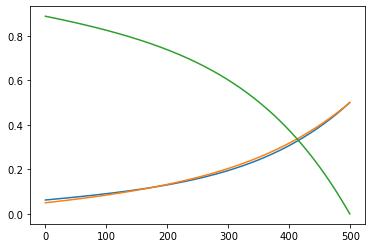

In [12]:
plt.plot(Alpha1)
plt.plot(Alpha2)
plt.plot(Alpha3)

In [21]:
x0 = -1.5
y0 = 1.2
theta0 = pi/10

xf = 0
yf = 0
thetaf = 0

In [13]:
x0 = -4
y0 = -0.9
theta0 = pi

xf = 0
yf = 0
thetaf = pi/2

In [22]:
opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

## les positions
x = opti.variable(n)
y = opti.variable(n)
theta = opti.variable(n)

## les vitesses 
v1 = opti.variable(n)        ## vitesse latérale
v2 = opti.variable(n)        ## vitesse orthogonal
w = opti.variable(n)         ## vitesse angulaire


## les accélération 
u1 = opti.variable(n)        ## accélération latérale
u3 = opti.variable(n)        ## accélération orthogonal
u2 = opti.variable(n)        ## accélération angulaire


opti.minimize(  taux*( dot(Alpha1 *u1,u1) +  dot(Alpha2 *u2,u2 ) + dot(Alpha3 *  u3 ,u3 ) ) )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

## pour les condition initial
opti.subject_to( x[0] == x0 + 10**(-4))       
opti.subject_to( y[0] == y0 + 10**(-4))    
opti.subject_to( theta[0] == theta0 + 10**(-4))

        
opti.subject_to( v1[0] == 0.0001 )
opti.subject_to( w[0] == 0.0001 )
opti.subject_to( v2[0] == 0.0001 )
opti.subject_to( v1[-1] == 0.0001 )
opti.subject_to( w[-1] == 0.0001 )
opti.subject_to( v2[-1] == 0.0001 )

opti.subject_to( u1[-1] == 0.0001 )
opti.subject_to( u2[-1] == 0.0001 )
opti.subject_to( u3[-1] == 0.0001 )

opti.subject_to( u1[0] == 0.0001 )
opti.subject_to( u2[0] == 0.0001 )
opti.subject_to( u3[0] == 0.0001 )



    ## pour les contraintes d'égaliter
opti.subject_to( x[1:] + 10**(-4) == x[:n-1]+taux*(cos(theta[:n-1])*v1[:n-1] - sin(theta[:n-1])*v2[:n-1]) )
opti.subject_to( y[1:] + 10**(-4) == y[:n-1]+taux*(sin(theta[:n-1])*v1[:n-1] + cos(theta[:n-1])*v2[:n-1]) )
opti.subject_to( theta[1:] + 10**(-4) == theta[:n-1] + taux*w[:n-1] )
opti.subject_to( (v1[:n-1] + taux* u1[:n-1] == v1[1:] + 10**(-4))  )
opti.subject_to( (v2[:n-1] + taux* u3[:n-1] == v2[1:] + 10**(-4)) )
opti.subject_to( (w[:n-1] + taux* u2[:n-1] == w[1:] + 10**(-4)) )
    

    ## pour les conditions finales
opti.subject_to( x[-1]==xf + 10**(-4))
opti.subject_to( y[-1]==yf + 10**(-4))
opti.subject_to( theta[-1]==thetaf + 10**(-4))


opti.solver('ipopt')      # suivant la méthode de KKT

sol = opti.solve()


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2997

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3012
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.50e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [23]:
U1 = sol.value(u1)
U2 = sol.value(u2)
U3 = sol.value(u3)
V1 = sol.value(v1)
W = sol.value(w)
V2 = sol.value(v2)
X = sol.value(x)
Y = sol.value(y)
THETA = sol.value(theta)

In [24]:
A0,B0,C0 = MH_IOC (X,Y,THETA,V1,W,V2,U1,U2,U3)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     9000
Number of nonzeros in inequality constraint Jacobian.:     9000
Number of nonzeros in Lagrangian Hessian.............:    22581

Total number of variables............................:     3036
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      500
Total number of inequality constraints...............:     1500
        inequality constraints with only lower bounds:     1500
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [25]:
C1_KKT = A0[0] + A0[1]*t + A0[2]* (t**2) + A0[3]* (t**3) + A0[4]* (t**4) + A0[5]* (t**5)
C2_KKT = B0[0] + B0[1]*t + B0[2]* (t**2) + B0[3]* (t**3) + B0[4]* (t**4) + B0[5]* (t**5) 
C3_KKT = C0[0] + C0[1]*t + C0[2]* (t**2) + C0[3]* (t**3) + C0[4]* (t**4) + C0[5]* (t**5) 

In [26]:
opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

## les positions
x = opti.variable(n)
y = opti.variable(n)
theta = opti.variable(n)

## les vitesses 
v1 = opti.variable(n)        ## vitesse latérale
v2 = opti.variable(n)        ## vitesse orthogonal
w = opti.variable(n)         ## vitesse angulaire


## les accélération 
u1 = opti.variable(n)        ## accélération latérale
u3 = opti.variable(n)        ## accélération orthogonal
u2 = opti.variable(n)        ## accélération angulaire


opti.minimize(  taux*( dot(C1_KKT *u1,u1) +  dot(C2_KKT *u2,u2 ) + dot(C3_KKT *  u3 ,u3 ) ) )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

## pour les condition initial
opti.subject_to( x[0] == x0 + 10**(-4))       
opti.subject_to( y[0] == y0 + 10**(-4))    
opti.subject_to( theta[0] == theta0 + 10**(-4))

        
opti.subject_to( v1[0] == 0.0001 )
opti.subject_to( w[0] == 0.0001 )
opti.subject_to( v2[0] == 0.0001 )
opti.subject_to( v1[-1] == 0.0001 )
opti.subject_to( w[-1] == 0.0001 )
opti.subject_to( v2[-1] == 0.0001 )

opti.subject_to( u1[-1] == 0.0001 )
opti.subject_to( u2[-1] == 0.0001 )
opti.subject_to( u3[-1] == 0.0001 )

opti.subject_to( u1[0] == 0.0001 )
opti.subject_to( u2[0] == 0.0001 )
opti.subject_to( u3[0] == 0.0001 )



    ## pour les contraintes d'égaliter
opti.subject_to( x[1:] + 10**(-4) == x[:n-1]+taux*(cos(theta[:n-1])*v1[:n-1] - sin(theta[:n-1])*v2[:n-1]) )
opti.subject_to( y[1:] + 10**(-4) == y[:n-1]+taux*(sin(theta[:n-1])*v1[:n-1] + cos(theta[:n-1])*v2[:n-1]) )
opti.subject_to( theta[1:] + 10**(-4) == theta[:n-1] + taux*w[:n-1] )
opti.subject_to( (v1[:n-1] + taux* u1[:n-1] == v1[1:] + 10**(-4))  )
opti.subject_to( (v2[:n-1] + taux* u3[:n-1] == v2[1:] + 10**(-4)) )
opti.subject_to( (w[:n-1] + taux* u2[:n-1] == w[1:] + 10**(-4)) )
    

    ## pour les conditions finales
opti.subject_to( x[-1]==xf + 10**(-4))
opti.subject_to( y[-1]==yf + 10**(-4))
opti.subject_to( theta[-1]==thetaf + 10**(-4))


opti.solver('ipopt')      # suivant la méthode de KKT

sol = opti.solve()


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2997

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3012
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.50e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [27]:
U1_KKT = sol.value(u1)
U2_KKT = sol.value(u2)
U3_KKT = sol.value(u3)
V1_KKT = sol.value(v1)
W_KKT = sol.value(w)
V2_KKT = sol.value(v2)
X_KKT = sol.value(x)
Y_KKT = sol.value(y)
THETA_KKT = sol.value(theta)

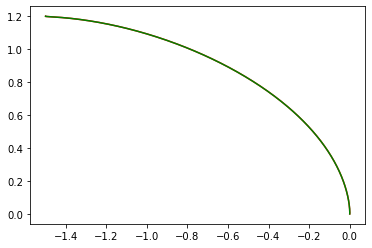

In [28]:
plt.plot(X,Y,'r')
plt.plot(X_KKT,Y_KKT,'green')